In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns
import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'

In [3]:
# person = "Alexander Hamilton"
# reasoning_question  = "What is the capital of the state that the first U.S. secretary of the treasury died in?"

In [4]:
person = "Hillary Clinton"
reasoning_question = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"

# Load model and extractor

In [5]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
activation_extractor.overwrite_chat_template()

# Construct probes

In [7]:
import nltk
import random
from nltk.corpus import brown

nltk.download('brown')

def get_frequent_words(count=50):
    # Get all words from the Brown corpus
    word_list = brown.words()
    
    # Filter shorter, simpler words
    filtered_words = [word.lower() for word in word_list if len(word) <= 8 and word.isalpha()]
    
    # Get unique words and sample
    unique_words = list(set(filtered_words))
    random.seed(0)
    sampled_words = random.sample(unique_words, count)
    random.seed()
    return sampled_words

randomly_sampled_words = get_frequent_words()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [8]:
print(randomly_sampled_words)

['targets', 'saluted', 'ripples', 'book', 'apaches', 'ludwick', 'sitwell', 'aliquots', 'lars', 'rocket', 'yolk', 'effect', 'poland', 'weil', 'kellum', 'budgets', 'familial', 'outfield', 'defeat', 'gaggle', 'shove', 'nagasaki', 'splits', 'date', 'cubans', 'judge', 'slave', 'brandon', 'olivetti', 'footpath', 'orange', 'derriere', 'breath', 'steels', 'aligned', 'sims', 'soaring', 'netting', 'wil', 'haircuts', 'doubts', 'pegboard', 'floor', 'arc', 'infinity', 'accorded', 'whitney', 'marquees', 'hi', 'signing']


In [9]:
def get_probe(activation_extractor, prompt=None, role="assistant"):
    # List of prompts to process
    if prompt is None:
        prompts = randomly_sampled_words
    else:
        prompts = [prompt]

    # Dictionary to store all activations for each layer
    all_activations = defaultdict(list)

    # Process each prompt
    for prompt in prompts:
        if role == 'assistant':
            prompt = "<think>\n</think>\n\n" + prompt
        print(f"Processing prompt: '{prompt}'")

        # Format the prompt
        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': role, 'content': prompt}],
            tokenize=False,
        )
        formatted  = formatted.split(activation_extractor.tokenizer.eos_token)[0]

        # Get activations
        print(formatted)
        results = activation_extractor.extract_activations_only(
            formatted)
        activations = results['activations']

        # Store the last token activations for each layer
        for key in activations.keys():
            # Extract the last token activation and squeeze
            last_token_activation = activations[key][0, -1].squeeze()
            all_activations[key].append(last_token_activation)

    # Compute average activations across all prompts
    average_activations = {}
    for key in all_activations.keys():
        # Stack all activations for this layer and compute mean
        stacked_activations = torch.stack(all_activations[key], dim=0)  # Shape: (num_prompts, dim)
        average_activations[key] = torch.mean(stacked_activations, dim=0)  # Shape: (dim,)
    return average_activations

In [10]:
chat_probes = get_probe(activation_extractor, person)

Processing prompt: '<think>
</think>

Hillary Clinton'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

Hillary Clinton


In [11]:
null_probes = get_probe(activation_extractor)

Processing prompt: '<think>
</think>

targets'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

targets
Processing prompt: '<think>
</think>

saluted'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

saluted
Processing prompt: '<think>
</think>

ripples'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

ripples
Processing prompt: '<think>
</think>

book'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

book
Processing prompt: '<think>
</think>

apaches'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

apaches
Processing prompt: '<think>
</think>

ludwick'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

ludwick
Processing prompt: '<think>
</think>

sitwell'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

sitwell
Processing prompt: '<think>
</think>

aliquots'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

aliquots
Processing prompt: '<think>
</think>

lars'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

lars
Processing prompt: '<think>
</think>

rocket'
<

In [12]:
baseline_subtracted_probes = {}
for k in chat_probes.keys():
    # Subtract the null probe activations from the chat probe activations
    baseline_subtracted_probes[k] = chat_probes[k] - null_probes[k]

# Get model activations to reasoning question

In [13]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)

In [14]:
n_iters = 15
all_results = []
for _ in range(n_iters):
    generation_results = activation_extractor.generate_with_activations(
        formatted,
        do_sample=True,
        temperature=0.3,
        max_new_tokens=1000,
    )
    all_results.append(generation_results)

# Get alignments

In [15]:
import editdistance
from typing import List, Tuple, Optional

def find_best_token_subsequence(response_tokens: List[str], target: str = "Alexander Hamilton", 
                               tolerance: float = 0.2) -> Optional[Tuple[int, int, str, float]]:
    """
    Find the subsequence of tokens that constructs a string most similar to the target.
    
    Args:
        response_tokens: List of token strings from the model output
        target: Target string to match (default: "Alexander Hamilton")
        tolerance: Maximum edit distance as fraction of target length (default: 0.2)
    
    Returns:
        Tuple of (start_idx, end_idx, matched_string, similarity_score) or None if no match found
        similarity_score = 1 - (edit_distance / target_length)
    """
    target_lower = target.lower()
    max_edit_distance = int(len(target) * tolerance)
    
    best_match = None
    best_score = -1
    
    # Try all possible contiguous subsequences
    for start_idx in range(len(response_tokens)):
        current_string = ""
        
        for end_idx in range(start_idx, len(response_tokens)):
            # Add current token to the string
            current_string += response_tokens[end_idx]
            current_lower = current_string.lower()
            
            # Calculate edit distance
            edit_dist = editdistance.eval(current_lower, target_lower)
            
            # Check if within tolerance
            if edit_dist <= max_edit_distance:
                similarity_score = 1 - (edit_dist / len(target))
                
                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = (start_idx, end_idx, current_string, similarity_score)
            
            # Early stopping: if string is already much longer than target, skip
            if len(current_string) > len(target) * 2:
                break
    
    return best_match

def find_all_matches(response_tokens: List[str], target: str = "Alexander Hamilton", 
                    tolerance: float = 0.2) -> List[Tuple[int, int, str, float]]:
    """
    Find all subsequences that match the target within tolerance, sorted by similarity.
    
    Returns:
        List of (start_idx, end_idx, matched_string, similarity_score) tuples
    """
    target_lower = target.lower()
    max_edit_distance = int(len(target) * tolerance)
    
    matches = []
    
    for start_idx in range(len(response_tokens)):
        current_string = ""
        
        for end_idx in range(start_idx, len(response_tokens)):
            current_string += response_tokens[end_idx]
            current_lower = current_string.lower()
            
            edit_dist = editdistance.eval(current_lower, target_lower)
            
            if edit_dist <= max_edit_distance:
                similarity_score = 1 - (edit_dist / len(target))
                matches.append((start_idx, end_idx, current_string, similarity_score))
            
            if len(current_string) > len(target) * 2:
                break
    
    # Sort by similarity score (descending)
    matches.sort(key=lambda x: x[3], reverse=True)
    
    # Filter out overlapping matches - keep only the best match for each overlapping group
    return filter_overlapping_matches(matches)

def filter_overlapping_matches(matches: List[Tuple[int, int, str, float]]) -> List[Tuple[int, int, str, float]]:
    """
    Filter out overlapping matches, keeping only the best match for each overlapping group.
    
    Args:
        matches: List of (start_idx, end_idx, matched_string, similarity_score) tuples, 
                sorted by similarity score (descending)
    
    Returns:
        Filtered list with no overlapping matches
    """
    if not matches:
        return []
    
    filtered = []
    
    for current_match in matches:
        current_start, current_end = current_match[0], current_match[1]
        
        # Check if this match overlaps with any already selected match
        overlaps = False
        for selected_match in filtered:
            selected_start, selected_end = selected_match[0], selected_match[1]
            
            # Check for overlap: ranges [a,b] and [c,d] overlap if max(a,c) <= min(b,d)
            if max(current_start, selected_start) <= min(current_end, selected_end):
                overlaps = True
                break
        
        # If no overlap, add to filtered results
        if not overlaps:
            filtered.append(current_match)
    
    return filtered

# Run probe through model activations

In [16]:
# Find best match
df = {
    'offset': [],
    'alignment': [],
    'layer': [],
    'correlation': []
}
for result in all_results:
    translated_response = result['response_tokens']
    translated_response = [rot13_alpha(token) for token in translated_response]
    token_search_result = find_best_token_subsequence(translated_response, target=person)
    end_think_idx = np.argwhere(np.array(result['response_tokens']) == "</think>")
    if end_think_idx.size != 0:
        end_think_idx = end_think_idx.item()
    else:
        end_think_idx = len(translated_response)
    if token_search_result:
        start_idx, end_idx, _, _ = token_search_result
        for key in baseline_subtracted_probes.keys():
            layer = int(key.split('_')[-1])
            model_response = result['token_activations'][key].squeeze()
            model_response = model_response[:end_think_idx]
            model_response_norm = F.normalize(model_response, p=2, dim=-1)
            baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[key], p=2, dim=-1)
            probe_sim = model_response_norm @ baseline_subtracted_probe
            probe_sim = probe_sim.to(torch.float32).numpy()

            # Aligned to token response
            df['offset'].extend([i-end_idx for i in range(probe_sim.shape[0])])
            df['alignment'].extend(["Subject Aligned"] * probe_sim.shape[0])
            df['layer'].extend([layer] * probe_sim.shape[0])
            df['correlation'].extend(probe_sim.tolist())

            # Random alignment
            random_idx = np.random.randint(0, end_think_idx)
            df['offset'].extend([i-random_idx for i in range(probe_sim.shape[0])])
            df['alignment'].extend(["Random Aligned"] * probe_sim.shape[0])
            df['layer'].extend([layer] * probe_sim.shape[0])
            df['correlation'].extend(probe_sim.tolist())
    else:
        print(f"No match found within tolerance: {rot13_alpha(result['response'])}")

In [17]:
pd_df = pd.DataFrame(df)

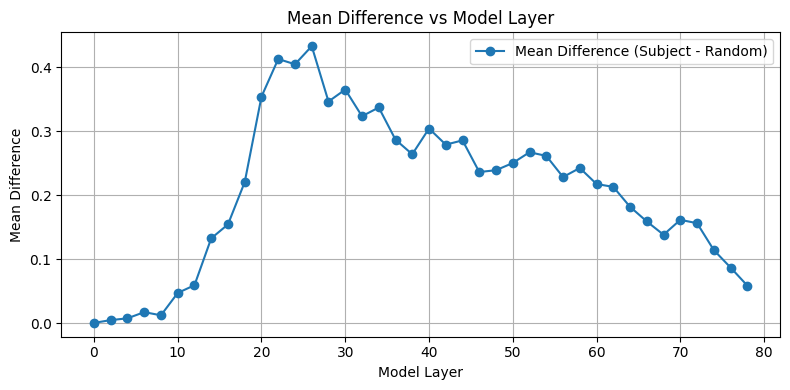

In [18]:
# Calculate the difference between mean values at offset 0 for each layer
layer_differences = []
layers = np.sort(np.unique(pd_df['layer']))

for layer in layers:
    layer_df = pd_df[pd_df['layer'] == layer]
    
    # Filter "Subject Aligned" and "Random Aligned" data at offset 0
    subject_aligned_df = layer_df[(layer_df['alignment'] == "Subject Aligned") & (layer_df['offset'] == 0)]
    random_aligned_df = layer_df[(layer_df['alignment'] == "Random Aligned") & (layer_df['offset'] == 0)]
    
    # Calculate mean values
    subject_mean = subject_aligned_df['correlation'].mean()
    random_mean = random_aligned_df['correlation'].mean()
    
    # Calculate difference and store it
    difference = subject_mean - random_mean
    layer_differences.append(difference)

# Plot the difference vs model layer
plt.figure(figsize=(8, 4))
plt.plot(layers, layer_differences, marker='o', label="Mean Difference (Subject - Random)")
plt.title("Mean Difference vs Model Layer", fontsize=12)
plt.xlabel("Model Layer", fontsize=10)
plt.ylabel("Mean Difference", fontsize=10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
formatted_person = person.lower().replace(" ", "_")
with PdfPages(f"baseline_subtracted_probe_summary_{formatted_person}.pdf") as pdf:
    for layer in np.sort(np.unique(pd_df['layer'])):
        fig, ax = plt.subplots(figsize=(10,1))
        layer_df = pd_df[pd_df['layer']==layer]
        for alignment in ["Subject Aligned", "Random Aligned"]:
            alignment_df = layer_df[layer_df['alignment'] == alignment]
            filtered_df = alignment_df.groupby('offset').filter(lambda x: len(x) > 1)
            sns.lineplot(
                x="offset", y="correlation",
                ax=ax, data=filtered_df, label=alignment)
        plt.title(f"Layer {layer}", fontsize=8)
        plt.ylabel('Cos Sim.', fontsize=8)
        plt.xlabel("Token Offset", fontsize=8)
        plt.ylim(0, 1)
        plt.legend()
    
        # Save the current figure to the PDF instead of showing it
        pdf.savefig(bbox_inches='tight')
        plt.close() 

In [32]:
for result in all_results:
    print(rot13_alpha(result['response']))



Okay, so I need to figure out the capital of the state where the U.S. Secretary of State in 2009 was born. Let me break this down step by step.

First, I should identify who the Secretary of State was in 2009. I remember that Hillary Clinton was the Secretary of State during that time. She was appointed by President Barack Obama and served from 2009 to 2013. So, that's the first part.

Next, I need to find out where Hillary Clinton was born. I think she was born in Chicago, Illinois. I've heard that before, but I'm not 100% sure. Let me double-check that. Yes, Hillary Clinton was born in Chicago, Illinois, on October 26, 1947.

Now, the question is asking for the capital of the state where she was born. Since she was born in Illinois, I need to find the capital of Illinois. I know that Springfield is the capital of Illinois. It's where the state capitol is located, and it's the largest city in the state after Chicago.

Wait, just to make sure I'm not mixing anything up. Sometimes peo